In [15]:
############ Calculate Horizon Distances #################
import pycbc.psd
import numpy

from pycbc.waveform import get_fd_waveform
from pycbc.filter import sigma
from pycbc.cosmology import redshift

import tqdm

dur = 8
sr = 8192
flow = 5.2
df = 1.0 / dur
tlen = sr * dur
flen = tlen // 2 + 1

ce_40k_base = pycbc.psd.from_txt("ce_strain/cosmic_explorer_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

det_masses = numpy.logspace(-1, 3.6, 100)

signal_amp = []

for m in tqdm.tqdm(det_masses):
    hp, hc = get_fd_waveform(approximant="IMRPhenomXPHM",
                             mass1=m,
                             mass2=m,
                             f_lower=flow,
                             delta_f=df,
                             )
    hp.resize(len(ce_40k_base))
    amp = sigma(hp, psd=ce_40k_base, low_frequency_cutoff=flow)
    signal_amp.append(amp)
    
ce_40k_limit = ce_40k_base / 10.0 # approximation for mockup
signal_amp_limit = []
for m in tqdm.tqdm(det_masses):
    hp, hc = get_fd_waveform(approximant="IMRPhenomXPHM",
                             mass1=m,
                             mass2=m,
                             f_lower=flow,
                             delta_f=df,
                             )
    hp.resize(len(ce_40k_limit))
    amp = sigma(hp, psd=ce_40k_limit, low_frequency_cutoff=flow)
    signal_amp_limit.append(amp)
    

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s]


In [6]:
########### Generate Populations ################
from pycbc.distributions import draw_samples_from_config

bns = draw_samples_from_config('populations/bns.ini', int(1e6))
bbh = draw_samples_from_config('populations/bbh.ini', int(1e5))

/home/ahnitz/projects/env/lib64/python3.11/site-packages/pycbc/distributions/external.py:191: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  norm_const = scipy_integrate.quad(
/home/ahnitz/projects/env/lib64/python3.11/site-packages/pycbc/distributions/external.py:210: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  cdf_x = scipy_integrate.quad(


In [105]:
# Generate fiducial pop III population # placeholder
import numpy.random
psize = 100
popthree = {}
popthree['redshift'] = numpy.random.normal(17, 5, size=psize)
popthree['mass'] = numpy.random.normal(60, 20, size=psize)
# quick and dirty eyeball from here temporarily 2303.15515.pdf

In [114]:
# Generate fiducial  QCD Phase transition PBHs #placeholder
import numpy.random
psize = 1000
pbh = {}
pbh['redshift'] = numpy.random.uniform(0, 300, size=psize)
pbh['mass'] = numpy.random.normal(0.7*2.0, 1.0, size=psize)

Text(0.7, 5, 'Primordial QCD BHs')

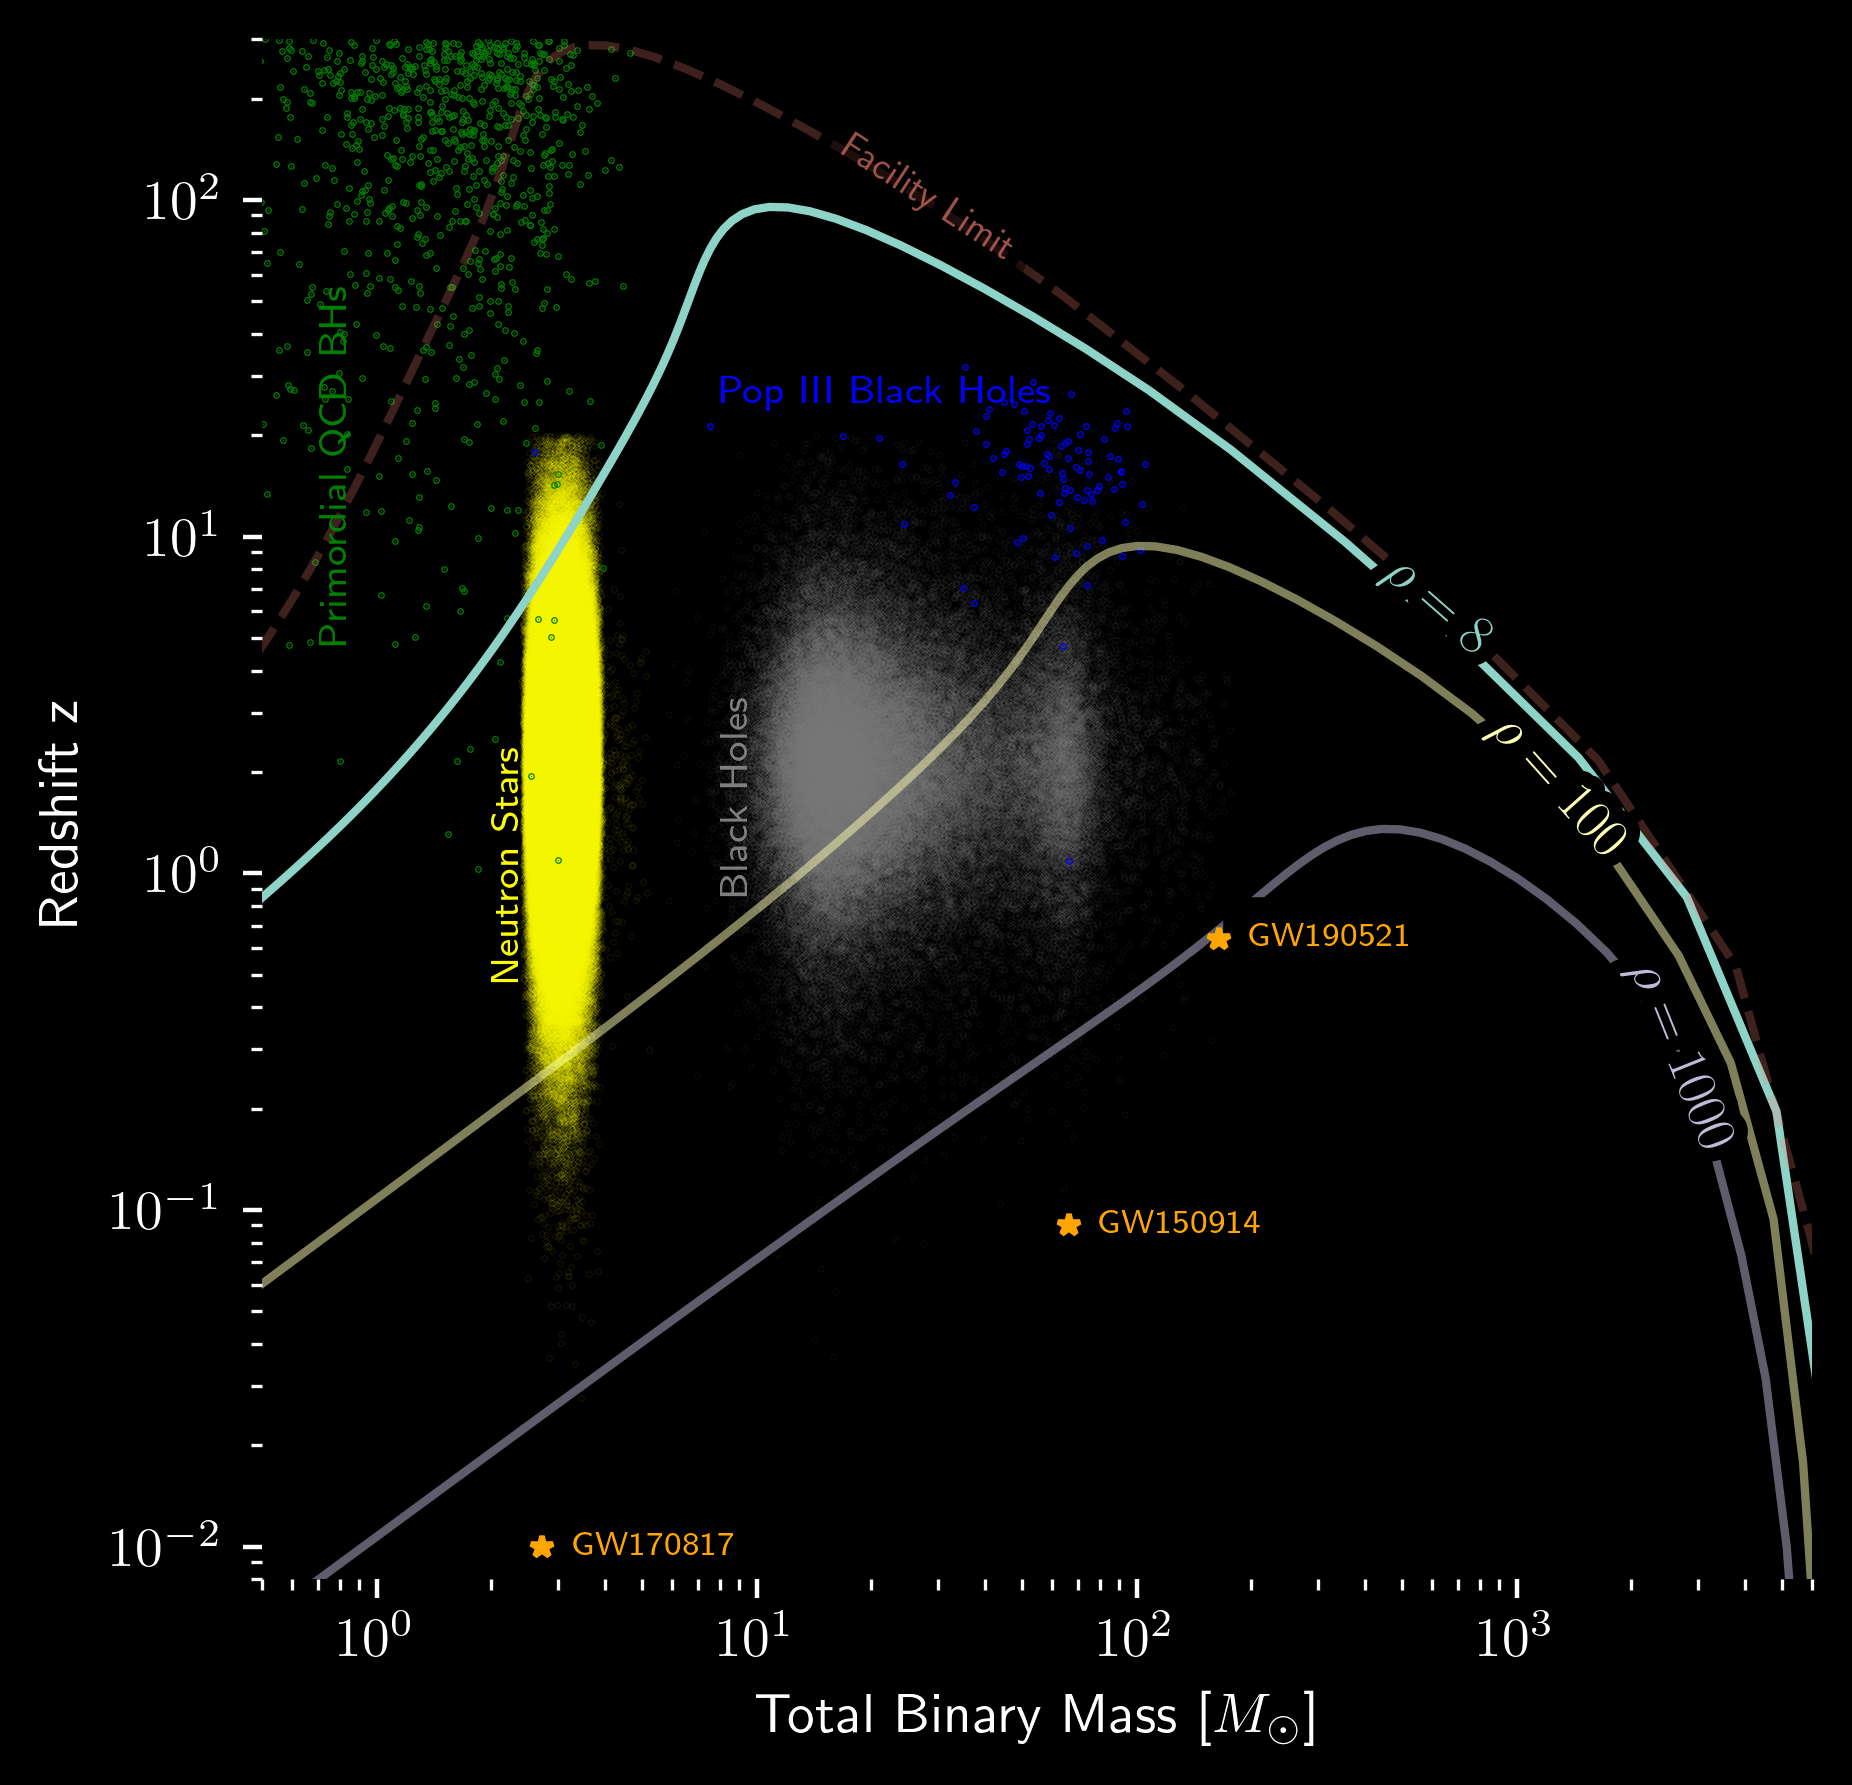

In [115]:
# Make plot ##########
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines, labelLine

plt.figure(figsize=[5, 5], dpi=400)
plt.style.use('dark_background')
plt.rc('text', usetex=True)

plt.ylim(0.008, 300)
plt.xlim(0.5, 6000)
#plt.xlim(1, 300)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Binary Mass [$M_\odot$]')
plt.ylabel('Redshift z')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# add horizon distance lines ####################################
    
for snr, alpha in zip([8, 100, 1000], [1, 0.5, 0.5]):
    ldist_horizon = numpy.array(signal_amp) / snr

    z = redshift(ldist_horizon)
    src_mass = det_masses / (1 + z)
    plt.plot(src_mass * 2.0, z, label=f"$\\rho = {snr}$", alpha=alpha)
    
labelLines(plt.gca().get_lines(), align=True, fontsize=10)

# add facility horizon limit ###################################


ldist_horizon = numpy.array(signal_amp_limit) / 8.0

z = redshift(ldist_horizon)
src_mass = det_masses / (1 + z)
plt.plot(src_mass * 2.0, z, label=f"Facility Limit", linestyle='--', alpha=0.25)
    
labelLine(plt.gca().get_lines()[-1], 30.0, align=True, fontsize=7, alpha=0.5)

# add interesting single events#################################
from pycbc.catalog import Merger

m = Merger("GW170817")
x, y = m.mass1 + m.mass2, m.redshift
plt.plot(x, y, '*', color='orange', markersize=4, zorder=10)
plt.text(x*1.2, y/1.05, 'GW170817', fontsize=6, color='orange', zorder=9)

m = Merger("GW150914")
x, y = m.mass1 + m.mass2, m.redshift
plt.plot(x, y, '*', color='orange', markersize=4, zorder=10)
plt.text(x*1.2, y/1.05, 'GW150914', fontsize=6, color='orange', zorder=9)

m = Merger("GW190521", source='gwtc-2')
x, y = m.mass1 + m.mass2, m.redshift
plt.plot(x, y, '*', color='orange', markersize=4, zorder=10)
t = plt.text(x*1.2, y/1.05, 'GW190521', fontsize=6, color='orange', backgroundcolor='black', zorder=9)

##################################################
# Add populations of events

plt.scatter(bns['srcmass1'] + bns['srcmass2'], bns['redshift'], s=0.001, rasterized=True, alpha=0.5, color='yellow')
plt.text(2.0, .5, 'Neutron Stars', rotation=90, fontsize=7, color='yellow')

plt.scatter(bbh['srcmass1'] + bbh['srcmass2'], bbh['redshift'], s=0.001, rasterized=True, alpha=0.5, color='grey')
plt.text(8.0, .9, 'Black Holes', rotation=90, fontsize=7, color='grey')


plt.scatter(popthree['mass'], popthree['redshift'], color='blue', s=0.05, alpha=1.0)
plt.text(8.0, 25, 'Pop III Black Holes', fontsize=7, color='blue')

plt.scatter(pbh['mass'], pbh['redshift'], color='green', s=0.05, alpha=1.0)
plt.text(0.7, 5, 'Primordial QCD BHs', fontsize=7, rotation=90, color='green')
##################################################
# Add hypothetical populations